# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

Forecast all features together for multiple steps: pollution, dew, temp, press, wind_dir, wind_spd, snow, rain

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #matplotlib is used for plotting data
import matplotlib.ticker as ticker #used for changing tick spacing
import datetime as dt #used for dates
import matplotlib.dates as mdates #used for dates, in a different way
import keras
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [3]:
data = pd.read_csv("AirPollution.csv")
data.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [4]:
data["DateTime"] = pd.to_datetime(data["year"]*1000000+data["month"]*10000+data["day"]*100+data["hour"],format='%Y%m%d%H')
data = data.drop(["year", "month", "day", "hour", "No"], axis = 1)
data = data.rename(index=str, columns={"pm2.5": "pollution", "DEWP": "dew", "TEMP": "temp", "PRES": "press", "cbwd": "wind_dir", "Iws": "wind_spd", "Is": "snow", "Ir": "rain"})
data = data.set_index("DateTime")
data.head()

,pollution,dew,temp,press,wind_dir,wind_spd,snow,rain
DateTime,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


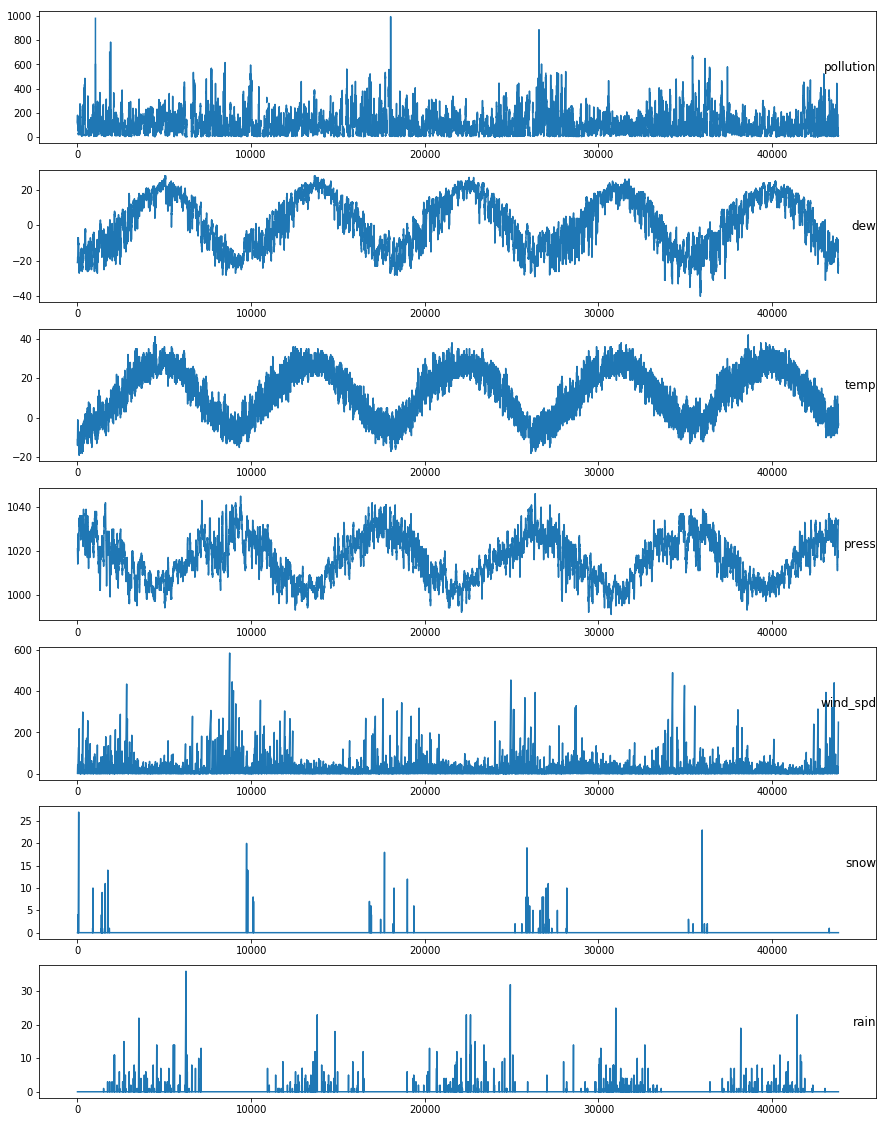

In [5]:
values = data.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 20
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [6]:
data["pollution"].isnull().sum()/len(data["pollution"]) #less than 5%, we could consider to drop it!

0.047165936473165387

In [7]:
data1 = data[np.isfinite(data['pollution'])]

In [8]:
data1.head()

,pollution,dew,temp,press,wind_dir,wind_spd,snow,rain
DateTime,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [40]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(n_out-1, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [49]:
values = data1.values
# integer encode direction
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 3)
# print(reframed.head())
# print(reframed.tail())
# print(scaled.shape)
# print(reframed.shape)

In [10]:
# reframed = series_to_supervised(scaled, 1, 2)
# # drop columns we don't want to predict
# # reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
# print(reframed.head())

In [50]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :8], train[:, 8:]
test_X, test_y = test[:, :8], test[:, 8:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760, 8) (32994, 1, 8) (32994, 8)


Train on 8760 samples, validate on 32994 samples
Epoch 1/100
 - 2s - loss: 0.1656 - val_loss: 0.1074
Epoch 2/100
 - 1s - loss: 0.0966 - val_loss: 0.1030
Epoch 3/100
 - 1s - loss: 0.0864 - val_loss: 0.0997
Epoch 4/100
 - 1s - loss: 0.0789 - val_loss: 0.0968
Epoch 5/100
 - 1s - loss: 0.0719 - val_loss: 0.0961
Epoch 6/100
 - 1s - loss: 0.0667 - val_loss: 0.0952
Epoch 7/100
 - 1s - loss: 0.0633 - val_loss: 0.0942
Epoch 8/100
 - 1s - loss: 0.0609 - val_loss: 0.0934
Epoch 9/100
 - 1s - loss: 0.0591 - val_loss: 0.0927
Epoch 10/100
 - 1s - loss: 0.0571 - val_loss: 0.0922
Epoch 11/100
 - 1s - loss: 0.0554 - val_loss: 0.0916
Epoch 12/100
 - 1s - loss: 0.0541 - val_loss: 0.0911
Epoch 13/100
 - 1s - loss: 0.0535 - val_loss: 0.0908
Epoch 14/100
 - 1s - loss: 0.0530 - val_loss: 0.0898
Epoch 15/100
 - 1s - loss: 0.0525 - val_loss: 0.0883
Epoch 16/100
 - 1s - loss: 0.0520 - val_loss: 0.0875
Epoch 17/100
 - 1s - loss: 0.0516 - val_loss: 0.0866
Epoch 18/100
 - 1s - loss: 0.0513 - val_loss: 0.0858
Epoch 

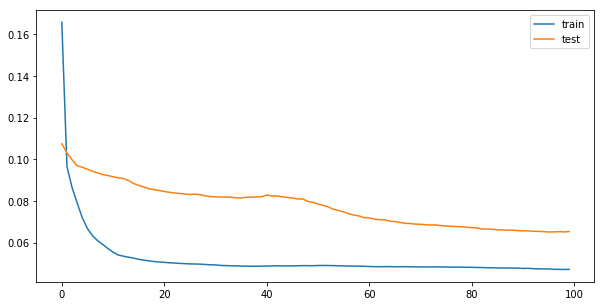

In [51]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import time

# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(8))
model.compile(loss='mae', optimizer='adam')
# fit network
start_time = time.time()
history = model.fit(train_X, train_y, epochs=100, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)
print("--- %s seconds ---" % (time.time() - start_time))
# plot history
rcParams['figure.figsize'] = 10, 5
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [56]:
# from math import sqrt
# from numpy import concatenate
# from sklearn.metrics import mean_squared_error

# # make a prediction
# yhat = model.predict(test_X)
# print(yhat.shape)
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# # invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, 8:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0:8]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 8))
# inv_y = concatenate((test_y, test_X[:, 8:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0:8]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
print('Test RMSE: %.3f for pollution' % rmse)
rmse = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,1]))
print('Test RMSE: %.3f for dew' % rmse)
rmse = sqrt(mean_squared_error(inv_y[:,2], inv_yhat[:,2]))
print('Test RMSE: %.3f for temp' % rmse)
rmse = sqrt(mean_squared_error(inv_y[:,3], inv_yhat[:,3]))
print('Test RMSE: %.3f for press' % rmse)
rmse = sqrt(mean_squared_error(inv_y[:,4], inv_yhat[:,4]))
print('Test RMSE: %.3f for wind_dir' % rmse)
rmse = sqrt(mean_squared_error(inv_y[:,5], inv_yhat[:,5]))
print('Test RMSE: %.3f for wind_spd' % rmse)
rmse = sqrt(mean_squared_error(inv_y[:,6], inv_yhat[:,6]))
print('Test RMSE: %.3f for snow' % rmse)
rmse = sqrt(mean_squared_error(inv_y[:,7], inv_yhat[:,7]))
print('Test RMSE: %.3f for rain' % rmse)

Test RMSE: 50.413 for pollution
Test RMSE: 7.323 for dew
Test RMSE: 5.365 for temp
Test RMSE: 2.088 for press
Test RMSE: 0.957 for wind_dir
Test RMSE: 36.883 for wind_spd
Test RMSE: 0.507 for snow
Test RMSE: 0.933 for rain
